In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# NB201
from nas_201_api import NASBench201API as API

from ntk import get_ntk_n
from linear_region_counter import Linear_Region_Collector

import scipy.stats as stats
import matplotlib.pyplot as plt

import tqdm

# custom
from custom_models import get_cell_based_tiny_net

In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='../../configs/nas-benchmark/algos/RANDOM.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
# parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
# parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--channel", type=int, default=3, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=1, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=0, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./results/tmp', help="Folder to save checkpoints and log.")
parser.add_argument("--arch_nas_dataset", type=str, default='../../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

90901
Namespace(arch_nas_dataset='../../NAS-Bench-201-v1_1-096897.pth', channel=3, config_path='../../configs/nas-benchmark/algos/RANDOM.config', data_path='../../cifar.python', dataset='cifar10', max_nodes=4, num_cells=1, print_freq=200, rand_seed=90901, save_dir='./results/tmp', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=0)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=results/tmp, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : ../../NAS-Bench-201-v1_1-096897.pth
channel          : 3
config_path      : ../../configs/nas-benchmark/algos/RANDOM.config
data_path        : ../../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 1
print_freq       : 200
rand_seed        : 90901
save_dir         : ./results/tmp
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 0
Python  Version  : 3.8.8 (default, Feb 24 2021, 21:46:12)  [GCC 7.3.0]
Pillow  Version  : 8.1.2
PyTorch Version  : 1.8.1
cuDNN   Version  : 8005
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


In [4]:
def kaiming_normal_fanin_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.ones_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)


def kaiming_normal_fanout_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.ones_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)


def init_model(model, method='kaiming_norm_fanin'):
    if method == 'kaiming_norm_fanin':
        model.apply(kaiming_normal_fanin_init)
    elif method == 'kaiming_norm_fanout':
        model.apply(kaiming_normal_fanout_init)
    return model

def pca_eig_diag(xloader, network, num_batch=1):
    device = torch.cuda.current_device()
    network.train()
    
    with torch.no_grad():
        feat_list = []
        for i, (inputs, targets) in enumerate(xloader):
            if num_batch > 0 and i >= num_batch: break

            inputs = inputs.cuda(device=device, non_blocking=True)
            network.zero_grad()
#             inputs_ = inputs.clone().cuda(device=device, non_blocking=True)
            inputs_ = torch.randn_like(inputs)
            _ = network(inputs_)
            feat = network.last_feature_map
            b,c,h,w = feat.size()
            feat_list.append(feat.permute(0,2,3,1).contiguous().view(b*h*w,c))

        feat = torch.cat(feat_list, dim=0)
        m = feat.mean(dim=0, keepdim=True)
        feat = feat - m
        sigma = torch.mm(feat.transpose(1,0),feat) / (b*h*w-1)
        u, s, v = torch.svd(sigma)
        prob_s = s / s.sum()
        score = 0
        for p in prob_s:
            score = score + (-p)*torch.log(p)
            
        torch.cuda.empty_cache()
    
    return score.item()

def search_find_best(xloader, network, lrc_model, archs):
    network.train()
    pca_scores, ntk_scores, lr_scores = [], [], []
    
    for i, arch in enumerate(tqdm.tqdm(archs)):
        # random sampling
#         arch = network.module.random_genotype(True)
        network.arch_cache = arch
    
        pca_score_tmp = []
        for _ in range(3):
            init_model(network)
            score = pca_eig_diag(xloader, network)
            pca_score_tmp.append(score)
        pca_score = np.mean(pca_score_tmp)
        
        ntk_score_tmp = []
        for _ in range(3):
            init_model(network)
            # ntk
            score = get_ntk_n(xloader, [network], recalbn=0, train_mode=True, num_batch=1)[0]
            ntk_score_tmp.append(-score)
        ntk_score = np.mean(ntk_score_tmp)
        
        lr_score_tmp = []
        for _ in range(3):
            init_model(network)
            lrc_model.reinit(models=[network], seed=xargs.rand_seed)
            score = lrc_model.forward_batch_sample()
            lr_score_tmp.append(score)
            lrc_model.clear()
        lr_score = np.mean(lr_score_tmp)
        
        pca_scores.append(pca_score)
        ntk_scores.append(ntk_score)
        lr_scores.append(lr_score)
        
    return pca_scores, ntk_scores, lr_scores
   
#     rank_ntk, rank_lr = stats.rankdata(ntk_scores), stats.rankdata(lr_scores)

#     rank_agg = rank_ntk + rank_lr

#     best_idx = np.argmax(rank_agg)
#     best_arch, best_ntk_score, best_lr_score = archs[best_idx], rank_ntk[best_idx], rank_lr[best_idx]

#     return best_arch, best_ntk_score, best_lr_score

# Main

In [5]:
## data
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, train_loader, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))


## model
search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

if xargs.arch_nas_dataset is None:
    api = None
else:
    api = API(xargs.arch_nas_dataset)
logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
# network = torch.nn.DataParallel(search_model).cuda()
network = search_model.cuda()

## LRC
lrc_model = Linear_Region_Collector(input_size=(100, 3, 3, 3), sample_batch=3, dataset=xargs.dataset, data_path=xargs.data_path, seed=xargs.rand_seed)


## misc
if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Files already downloaded and verified
Files already downloaded and verified
../../configs/nas-benchmark/algos/RANDOM.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
try to create the NAS-Bench-201 api from ../../NAS-Bench-201-v1_1-096897.pth
[2023-01-02 04:55:24] create API = NASBench201API(15625/15625 architectures, file=NAS-Bench-201-v1_1-096897.pth) done
Files already downloaded and verified
Files already downloaded and verified
=> do not find the last-info file : re

In [ ]:
num_samples = 100

fp_results = torch.load("./c3n1_1000samples.pth")
archs = fp_results['archs'][:num_samples]
fp_ntk_scores = fp_results['ntk_scores'][:num_samples]
fp_lr_scores = fp_results['lr_scores'][:num_samples]
api_valid_accs = fp_results['api_valid_accs'][:num_samples]
api_flops = fp_results['api_flops'][:num_samples]
api_params = fp_results['api_params'][:num_samples]

from custom_modules import QConv

for m in network.modules():
    if isinstance(m, QConv):
        m.set_q_range(32, 32)

q_pca_scores_32, q_ntk_scores_32, q_lr_scores_32 = search_find_best(train_loader, network, lrc_model, archs)

for m in network.modules():
    if isinstance(m, QConv):
        m.set_q_range(4, 4)

q_pca_scores_4, q_ntk_scores_4, q_lr_scores_4 = search_find_best(train_loader, network, lrc_model, archs)

for m in network.modules():
    if isinstance(m, QConv):
        m.set_q_range(1, 1)

q_pca_scores_1, q_ntk_scores_1, q_lr_scores_1 = search_find_best(train_loader, network, lrc_model, archs)

  2%|▏         | 24/1000 [03:38<2:39:39,  9.82s/it]

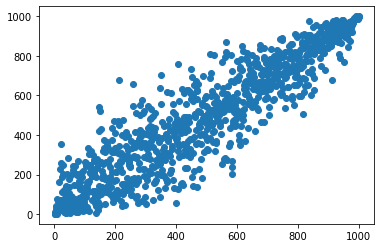

In [47]:
# plt.scatter(stats.rankdata(q_pca_scores_32),stats.rankdata(q_pca_scores_1))
# plt.xlim([-2000,10])
# plt.ylim([-2000,10])
# plt.scatter(q_ntk_scores_32,q_ntk_scores_32)
# plt.show()

# plt.scatter(q_pca_scores_32,q_pca_scores_4)
# plt.scatter(q_pca_scores_32,q_pca_scores_32)
# plt.show()

# plt.scatter(q_pca_scores_32,q_pca_scores_1)
# plt.scatter(q_pca_scores_32,q_pca_scores_32)
# plt.show()

# plt.scatter(q_ntk_scores_32,q_ntk_scores_4)
# plt.scatter(q_ntk_scores_32,q_ntk_scores_32)
# plt.show()

# plt.scatter(q_ntk_scores_32,q_ntk_scores_1)
# plt.scatter(q_ntk_scores_32,q_ntk_scores_32)
# plt.show()

# plt.scatter(q_lr_scores_32,q_lr_scores_4)
# plt.scatter(q_lr_scores_32,q_lr_scores_32)
# plt.show()

# plt.scatter(q_lr_scores_32,q_lr_scores_1)
# plt.scatter(q_lr_scores_32,q_lr_scores_32)
# plt.show()

In [ ]:
# %%capture
# # def get_valid_acc_from_api(api, arch):
# #     # print(api.query_by_arch(arch, "200"))
# #     index = api.query_index_by_arch(arch)
# #     results = api.query_by_index(index, 'cifar10-valid', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
# #     acc = 0
# #     for seed, result in results.items():
# #         acc = acc + result.get_eval('valid')['accuracy']
# #     acc = acc / len(results)
# #     return acc

# def get_results_from_api(api, arch):
#     # print(api.query_by_arch(arch, "200"))
#     index = api.query_index_by_arch(arch)
#     results = api.query_by_index(index, 'cifar10-valid', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
# #     results = api.query_by_index(index, 'cifar100', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
    
#     # valid acc
#     acc = 0
#     for seed, result in results.items():
#         acc = acc + result.get_eval('valid')['accuracy']
# #         acc = acc + result.get_eval('x-test')['accuracy']
#     acc = acc / len(results)
    
#     result = list(results.values())[0]
    
#     return acc, result.flop, result.params

# api_valid_accs, api_flops, api_params = [], [], []
# for a in archs:
#     valid_acc, flops, params = get_results_from_api(api, a)
#     api_valid_accs.append(valid_acc)
#     api_flops.append(flops)
#     api_params.append(params)

# # api_valid_accs = [get_valid_acc_from_api(api, a) for a in archs]

# Analysis

In [ ]:
# fp_results = torch.load("./c3n1_1000samples.pth")
# archs = fp_results['archs']
# fp_ntk_scores = fp_results['ntk_scores']
# fp_lr_scores = fp_results['lr_scores']
# api_valid_accs = fp_results['api_valid_accs']
# api_flops = fp_results['api_flops']
# api_params = fp_results['api_params']

# torch.save({"archs":archs,
#             "q_ntk_scores_32":q_ntk_scores_32,
#             "q_ntk_scores_4":q_ntk_scores_4,
#             "q_ntk_scores_1":q_ntk_scores_1,
#             "q_pca_scores_32":q_pca_scores_32,
#             "q_pca_scores_4":q_pca_scores_4,
#             "q_pca_scores_1":q_pca_scores_1,
#             "q_lr_scores_32":q_lr_scores_32,
#             "q_lr_scores_4":q_lr_scores_4,
#             "q_lr_scores_1":q_lr_scores_1,
#             "api_valid_accs":api_valid_accs,
#             "api_flops":api_flops,
#             "api_params":api_params,
#            },"./c3n1_1000samples_32_4_1.pth")

# torch.save({"archs":archs,
#             "fp_ntk_scores":fp_ntk_scores,
#             "fp_lr_scores":fp_lr_scores,
#             "q_ntk_scores":q_ntk_scores,
#             "q_lr_scores":q_lr_scores,
#             "api_valid_accs":api_valid_accs,
#             "api_flops":api_flops,
#             "api_params":api_params,
#            },"./c3n5_1000samples_1bit.pth")

# trained_results = torch.load("./c3n5_1000samples_4bit.pth")
# archs = trained_results['archs']
# fp_ntk_scores = trained_results['fp_ntk_scores']
# fp_lr_scores = trained_results['fp_lr_scores']
# q_ntk_scores = trained_results['q_ntk_scores']
# q_lr_scores = trained_results['q_lr_scores']
# api_valid_accs = trained_results['api_valid_accs']
# api_flops = trained_results['api_flops']
# api_params = trained_results['api_params']

RANDOM-NAS finds the best one : Structure(4 nodes with |none~0|+|none~0|nor_conv_1x1~1|+|none~0|skip_connect~1|avg_pool_3x3~2|) with ntk_score=-100000.0, lr_score=1.0
11.71521 0.101306



Call query_info_str_by_arch with arch=Structure(4 nodes with |none~0|+|none~0|nor_conv_1x1~1|+|none~0|skip_connect~1|avg_pool_3x3~2|) and hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |none~0|+|none~0|nor_conv_1x1~1|+|none~0|skip_connect~1|avg_pool_3x3~2|)
|none~0|+|none~0|nor_conv_1x1~1|+|none~0|skip_connect~1|avg_pool_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=2688
cifar10-valid  FLOP= 11.72 M, Params=0.101 MB, latency=13.14 ms.
cifar10-valid  train : [loss = 2.302, top1 = 10.29%], valid : [loss = 2.303, top1 = 9.71%]
cifar10        FLOP= 11.72 M, Params=0.101 MB, latency=13.14 ms.
cifar10        train : [loss = 2.303, top1 = 10.00%], test  : [loss = 2.303, top1 = 10.00%]
cifar100       FLOP= 11.72 M, Params=0.107 MB, late

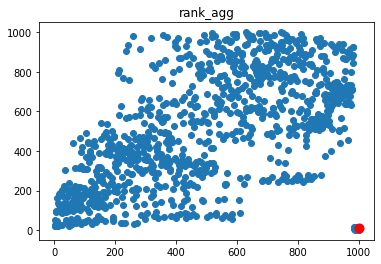

0.39941778301168146 9.11910786045664e-80


In [26]:
q_pca_scores = q_pca_scores_32
q_ntk_scores = q_ntk_scores_32
q_lr_scores = q_lr_scores_32

rank_pca, rank_ntk, rank_lr, rank_flops, rank_params = stats.rankdata(q_pca_scores), stats.rankdata(q_ntk_scores), stats.rankdata(q_lr_scores), stats.rankdata(api_flops), stats.rankdata(api_params)

l = len(q_ntk_scores)
rank_agg = np.log(rank_pca/l)
# rank_agg = np.log(rank_pca/l) + np.log(rank_ntk/l) + np.log(rank_lr/l) + np.log(rank_flops/l)
# rank_agg = rank_pca/l + rank_ntk/l + rank_lr/l + rank_flops/l

best_idx = np.argmax(rank_agg)
best_arch, best_ntk_score, best_lr_score, flops, params = archs[best_idx], q_ntk_scores[best_idx], q_lr_scores[best_idx], api_flops[best_idx], api_params[best_idx]

print("RANDOM-NAS finds the best one : {:} with ntk_score={:}, lr_score={:}".format(best_arch, best_ntk_score, best_lr_score))
print(flops, params)
print("\n\n")
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))

x = stats.rankdata(rank_agg)
y = stats.rankdata(api_valid_accs)
# y = api_valid_accs
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("rank_agg")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

In [ ]:
x = stats.rankdata(ntk_scores)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_confidences")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(lr_scores)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_confidences")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(api_flops)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_confidences")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(api_params)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_confidences")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

In [ ]:
index = api.query_index_by_arch(archs[0])
results = api.query_by_index(index, 'cifar10-valid', '200')
tmp = list(results.values())[0]
print(tmp)
print(tmp.params)
print(tmp.flop)